# Multi-resolution deconvolution of spatial transcriptomics in R


In this brief tutorial, we go over how to use scvi-tools functionality in R for analyzing spatial datasets. We will load spatial data following this Seurat [tutorial](https://satijalab.org/seurat/articles/spatial_vignette.html), subsequently analyzing the data using DestVI.

This tutorial requires Reticulate. Please check out our installation [guide](https://www.scvi-tools.org/en/latest/installation.html#scvi-tools-installation-for-R) for instructions on installing Reticulate and scvi-tools.

## Loading and processing data with Seurat

In [1]:
# install.packages("Seurat")
# install.packages("reticulate")
# install.packages("anndata")
# install.packages("devtools")
# devtools::install_github("satijalab/seurat-data")

# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install(c("LoomExperiment", "SingleCellExperiment"))
# devtools::install_github("cellgeni/sceasy")

In [2]:
library(Seurat)
library(SeuratData)
library(ggplot2)

Attaching SeuratObject

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used

First, we load the reference SMART-seq2 dataset of mouse brain. This dataset contains about 14,000 cells.

In [3]:
brain_sc_data <- readRDS(url("https://www.dropbox.com/s/cuowvm4vrf65pvq/allen_cortex.rds?dl=1"))

In [4]:
InstallData("stxBrain")

Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning me

In [5]:
brain_st_data <- LoadData("stxBrain", type = "anterior1")

Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(desc)) {:
“the condition has length > 1 and only the first element will be used”
Warning me

In [6]:
brain_sc_data

An object of class Seurat 
34617 features across 14249 samples within 1 assay 
Active assay: RNA (34617 features, 0 variable features)

In [7]:
brain_st_data

An object of class Seurat 
31053 features across 2696 samples within 1 assay 
Active assay: Spatial (31053 features, 0 variable features)

In [8]:
brain_sc_data <- NormalizeData(brain_sc_data, normalization.method = "LogNormalize", scale.factor = 10000)
brain_sc_data <- FindVariableFeatures(brain_sc_data, selection.method = "vst", nfeatures = 2000)
top2000 <- head(VariableFeatures(brain_sc_data), 2000)
top2000intersect <- intersect(rownames(brain_st_data), top2000)

In [9]:
brain_sc_data <- brain_sc_data[top2000intersect]
brain_st_data <- brain_st_data[top2000intersect]
G <- length(top2000intersect)
G

[1] 1752

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


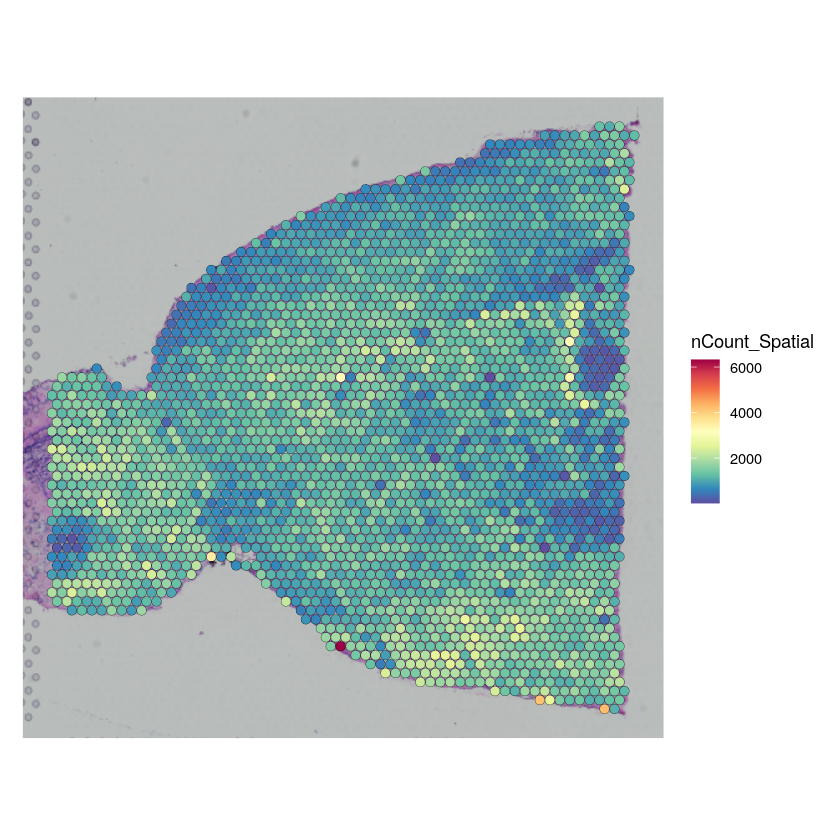

In [10]:
SpatialFeaturePlot(brain_st_data, features = "nCount_Spatial") + theme(legend.position = "right")

## Data conversion (Seurat -> AnnData)

We use sceasy for conversion, and load the necessary Python packages for later.

In [11]:
library(reticulate)
library(sceasy)
library(anndata)

sc <- import("scanpy", convert = FALSE)
scvi <- import("scvi", convert = FALSE)

We make two AnnData objects, one for the single-cell reference and one for the spatial transcriptomics data, and then move the measurement coordinates to the appropriate attribute of the spatial AnnData.

In [12]:
brain_sc_adata <- convertFormat(brain_sc_data, from="seurat", to="anndata", main_layer="counts", drop_single_values=FALSE)
brain_st_adata <- convertFormat(brain_st_data, from="seurat", to="anndata", assay="Spatial", main_layer="counts", drop_single_values=FALSE)

## Fit the scLVM

In [13]:
scvi$data$setup_anndata(brain_sc_adata, labels_key="class")

None

Here we would like to reweight each measurement by a scalar factor (e.g., the inverse proportion) in the loss of the model so that lowly abundant cell types get better fit by the model.

In [14]:
sclvm <- scvi$model$CondSCVI(brain_sc_adata, weight_obs=TRUE)
sclvm$train(max_epochs=as.integer(250))

None

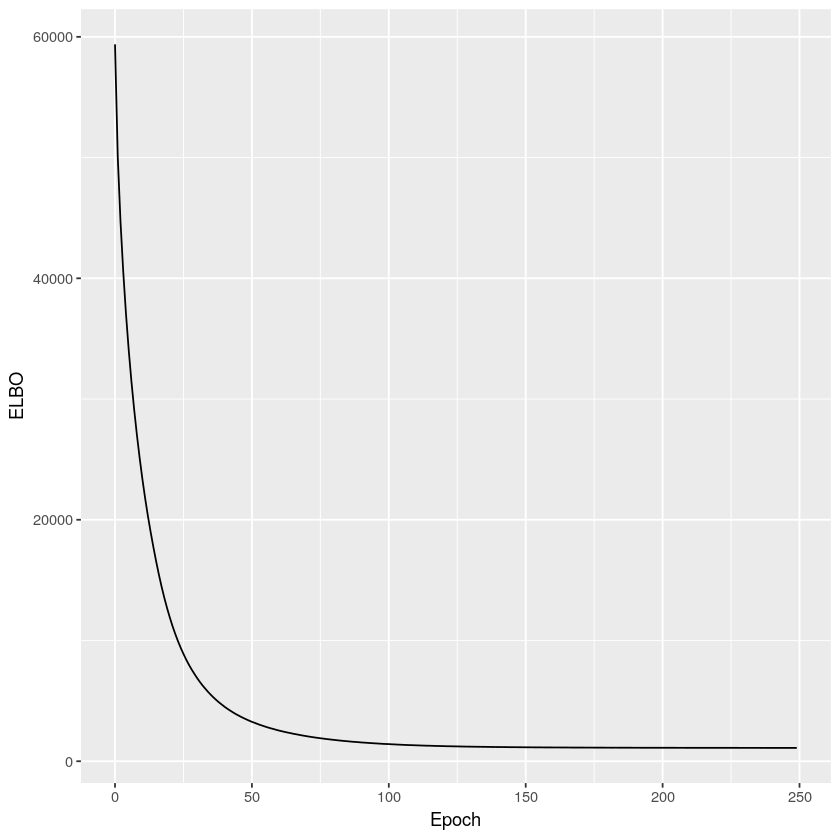

In [15]:
sclvm_elbo <- py_to_r(sclvm$history["elbo_train"]$astype("float64"))
ggplot(data = sclvm_elbo, mapping = aes(x=as.numeric(rownames(sclvm_elbo)), y=elbo_train)) + geom_line() + xlab("Epoch") + ylab("ELBO")

## Deconvolution with stLVM

In [16]:
scvi$data$setup_anndata(brain_st_adata)

None

In [17]:
stlvm <- scvi$model$DestVI$from_rna_model(brain_st_adata, sclvm)
stlvm$train(max_epochs=as.integer(2500))

None

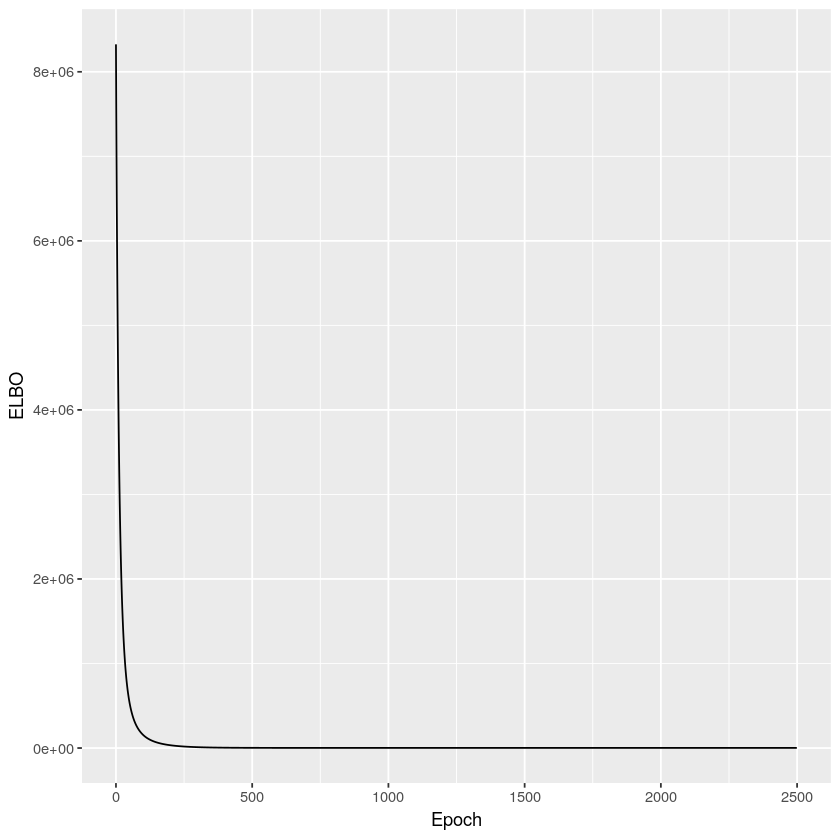

In [18]:
stlvm_elbo <- py_to_r(stlvm$history["elbo_train"]$astype("float64"))
ggplot(data = stlvm_elbo, mapping = aes(x=as.numeric(rownames(stlvm_elbo)), y=elbo_train)) + geom_line() + xlab("Epoch") + ylab("ELBO")

## Cell type proportions

In [19]:
brain_st_adata$obsm["proportions"] <- stlvm$get_proportions()

In [20]:
head(py_to_r(brain_st_adata$obsm$get("proportions")))

,Endothelial,GABAergic,Glutamatergic,Non-Neuronal
,<dbl>,<dbl>,<dbl>,<dbl>
AAACAAGTATCTCCCA-1,4.709790e-02,0.05343755,0.0243981164,0.8750663996
AAACACCAATAACTGC-1,6.490297e-01,0.29949406,0.0514145195,0.0000616809
AAACAGAGCGACTCCT-1,7.552048e-06,0.10886114,0.2187767178,0.6723545194
AAACAGCTTTCAGAAG-1,5.344343e-02,0.13574271,0.0276853275,0.7831285596
AAACAGGGTCTATATT-1,7.902017e-03,0.12160926,0.0341976732,0.8362910151
AAACATGGTGAGAGGA-1,6.177227e-01,0.38190839,0.0000614951,0.0003074519


In [21]:
brain_st_data[["predictions"]] <- CreateAssayObject(data = t(py_to_r(brain_st_adata$obsm$get("proportions"))))

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


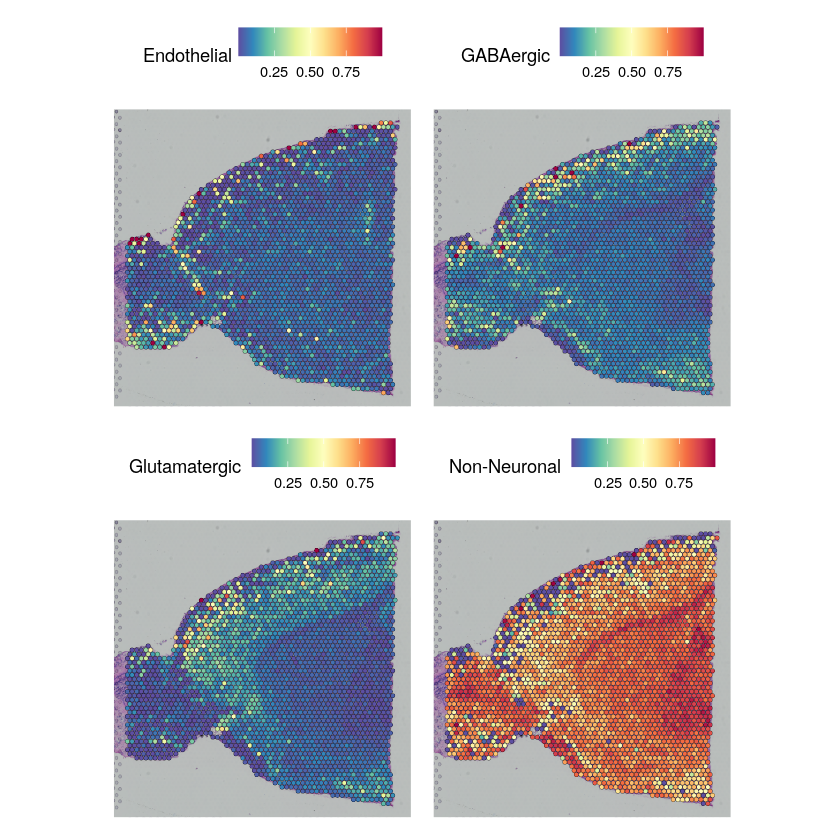

In [22]:
DefaultAssay(brain_st_data) <- "predictions"
SpatialFeaturePlot(brain_st_data, features = rownames(brain_st_data$predictions@meta.features))

## Intra cell type information

At the heart of DestVI is a multitude of latent variables (5 per cell type per spots). We refer to them as "gamma", and we may manually examine them for downstream analysis.

Because those values may be hard to examine for end-users, we presented several methods for prioritizing the study of different cell types (based on PCA and Hotspot). If you'd like to use those methods, please refer to our DestVI reproducibility repository. If you have suggestions to improve those, and would like to see them in the main codebase, reach out to us. 

In this tutorial, we assume that the user have identified key gene modules that vary within one cell type in the single-cell RNA sequencing data (e.g., using [Hotspot](https://github.com/YosefLab/Hotspot)). We provide here a code snippet for imputing the spatial pattern of the cell type specific gene expression, using the example of the PLP1 gene in Endothelial cells.

In [23]:
for (cell_type_gamma in iterate(stlvm$get_gamma()$items())) {
    cell_type <- cell_type_gamma[0]
    gamma_df <- cell_type_gamma[1]
    brain_st_data[[paste(cell_type, "gamma", sep = "")]] <- CreateAssayObject(data = t(py_to_r(gamma_df)))
}

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Non.Neuronalgamma; see ?make.names for more details on syntax validity”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from non.neuronalgamma_ to nonneuronalgamma_”


In [24]:
GetAssayData(brain_st_data$Endothelialgamma)

,AAACAAGTATCTCCCA-1,AAACACCAATAACTGC-1,AAACAGAGCGACTCCT-1,AAACAGCTTTCAGAAG-1,AAACAGGGTCTATATT-1,AAACATGGTGAGAGGA-1,AAACATTTCCCGGATT-1,AAACCGGGTAGGTACC-1,AAACCGTTCGTCCAGG-1,AAACCTAAGCAGCCGG-1,⋯,TTGTGCGGAAGCGGAT-1,TTGTGGCCCTGACAGT-1,TTGTGGTAGGAGGGAT-1,TTGTGGTGGTACTAAG-1,TTGTGTATGCCACCAA-1,TTGTGTTTCCCGAAAG-1,TTGTTCAGTGTGCTAC-1,TTGTTGTGTGTCAAGA-1,TTGTTTCACATCCAGG-1,TTGTTTCCATACAACT-1
0,-0.5365340,-0.5532320,-0.5396045,-0.5357823,-0.5387480,-0.5437819,-0.5362659,-0.5387465,-0.5575123,-0.5394445,⋯,-0.5379885,-0.5391976,-0.5360770,-0.5341644,-0.5382091,-0.5418506,-0.5393196,-0.5328479,-0.5352684,-0.5382047
1,-2.0472813,-2.0268085,-2.0343316,-2.0397313,-2.0392115,-2.0295587,-2.0343921,-2.0363631,-2.0209620,-2.0329566,⋯,-2.0347242,-2.0343475,-2.0369551,-2.0364590,-2.0310557,-2.0284054,-2.0353060,-2.0356274,-2.0363474,-2.0388231
2,1.4102036,1.4168870,1.4188076,1.4154204,1.4185746,1.4152712,1.4218757,1.4185205,1.4033962,1.4205869,⋯,1.4196583,1.4193764,1.4190459,1.4187257,1.4218929,1.4252501,1.4199588,1.4204195,1.4219873,1.4164648
3,1.8240334,1.8226118,1.8229667,1.8245422,1.8211607,1.8259348,1.8229930,1.8229731,1.8336475,1.8224734,⋯,1.8235134,1.8233124,1.8232815,1.8248205,1.8219368,1.8211279,1.8227546,1.8246264,1.8223506,1.8232423
4,-0.8288963,-0.8207338,-0.8195065,-0.8241755,-0.8199059,-0.8207973,-0.8186482,-0.8174921,-0.8167840,-0.8164706,⋯,-0.8176123,-0.8186037,-0.8209447,-0.8160424,-0.8213480,-0.8135237,-0.8180467,-0.8158950,-0.8148489,-0.8228828


In [25]:
ct_name <- "Glutamatergic"
gene_name <- "Plp1"

# filter for spots with low abundance
indices <- which(GetAssayData(brain_st_data$predictions)[ct_name,] > 0.03)

# impute gene
specific_expression <- stlvm$get_scale_for_ct(ct_name, indices = r_to_py(as.integer(indices - 1)))[[gene_name]]
specific_expression <- 1 + 1e4 * py_to_r(specific_expression$to_frame())

In [26]:
filtered_st_data <- brain_st_data[, indices]
filtered_st_data[["imputation"]] <- CreateAssayObject(data = t(specific_expression))

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


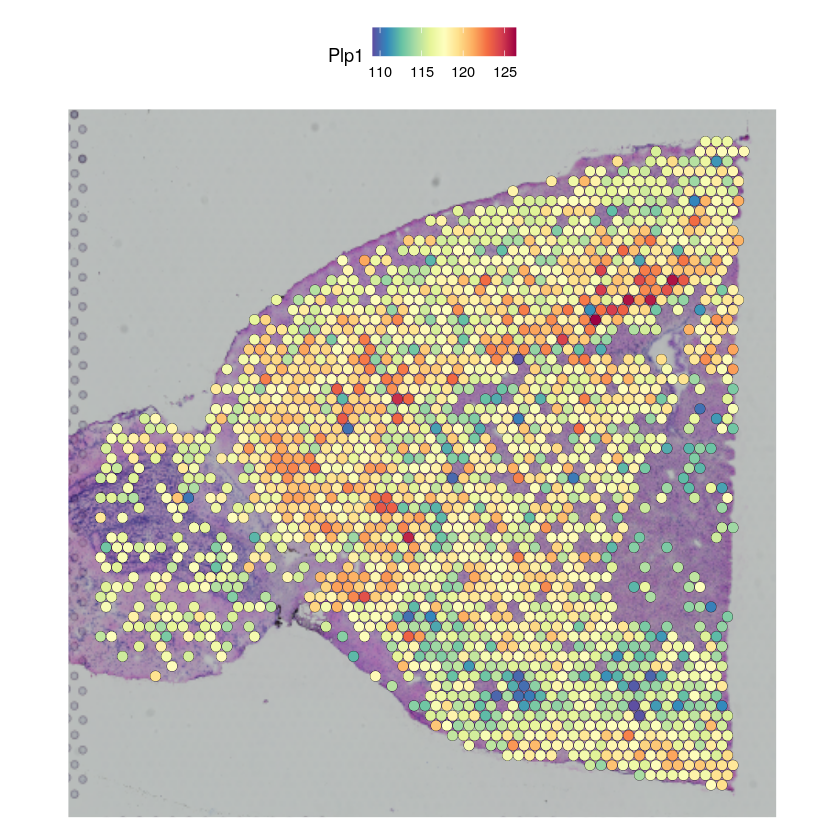

In [27]:
DefaultAssay(filtered_st_data) <- "imputation"
SpatialFeaturePlot(filtered_st_data, features = gene_name)

## Session Info

In [28]:
sI <- sessionInfo()
sI$loadedOnly <- NULL
print(sI, locale=FALSE)

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 16.04.6 LTS

Matrix products: default
BLAS/LAPACK: /data/yosef2/users/jhong/miniconda3/envs/r_tutorial/lib/libopenblasp-r0.3.12.so

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] anndata_0.7.5.3           sceasy_0.0.6             
[3] reticulate_1.22           ggplot2_3.3.5            
[5] stxBrain.SeuratData_0.1.1 SeuratData_0.2.1         
[7] SeuratObject_4.0.2        Seurat_4.0.4             
